In [1]:
# Scientific libraries
import numpy_html
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike') 
jtplot.style(context='talk', fscale=1, grid=False)

from glob import glob
import copy
import collections

#useful libraries
import daft

wine='#8F2727'

from betagen import betagen
dark, dark_highlight, mid, mid_highlight, light, light_highlight = betagen(wine)

import stan_utility

from bayescorner import bayescorner

#import warnings
#warnings.simplefilter('ignore')

# What is Bayes?

## Definition

Data are observed realizations of some model which has generated these observations. However, either due to the **model itself**, the uncertainty in **our understanding** of the model, and the **measurement process** itself, we must search for the probabilistic view of the model given our our observations.


![alt text](mod_config.png "Title")


This is encapsulated in Bayes' Theorem

$$\pi(\theta | \tilde{y})=\frac{\pi(\tilde{y}, \theta)}{\pi(\tilde{y})} \propto \pi(\tilde{y} | \theta) \pi(\theta) $$

One can see that if we take the prior to a constant, then we are left with the posterior being directly proportional to the likelihood. Thus, maximizing the likelihood is equivalent to maximizing the posterior. If we further assume that the posterior is symmetric or "Gaussian", we can derive the error distribution on our MLE point estimates. 

There is a lot of detail on the connection and derivability of MLE from Bayes' Theorem that we will not cover here. It is just important to know that Bayes' Theorem is the root of probabilistic inference of a model.

We can further visualize this process here:

![alt text](bayes_space.png "Title")

## Notation
### Probability 
Throughout, we will use some notation to describe data, distributions and probability. 

We begin with a probability:

$$ \pi(x) $$

which denote the probability of $x$. We define a conditional probability as:

$$\pi(x | y)$$

to be the probability of $x$ *given* $y$.

### Distributions

Often, we want to talk about the distribution of a quantity. We will use a short hand that is useful for **probabilistic programming languages** (PPLs) which we will discuss shortly. When we want to say $x$ is distributed as a Normal distribution, we write:

$$ x \sim \mathcal{N}(\mu, \sigma) \Leftrightarrow \pi(x | \mu, \sigma)$$.

 Other distributions are written the same way. For example, if $y$ is uniformly distributed:
 
 $$ y \sim \mathcal{U}(a,b)$$
 
 ### DAGs
 
 In many cases, it is easier to right a model as a directed graph. We will not make too much use of this in our work here, but it is important to be aware of them. Say we have observed data $\hat{x}$ which are generated by some latent process $x = f(\mu)$ with a prior over $\mu$. We could write this as 
 
 

<IPython.core.display.Javascript object>


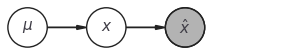

In [2]:
 pgm = daft.PGM((3.7, 0.7), origin=(0.15, 0.15))

pgm.add_node(daft.Node("mu", r"$\mu$", 0.5, 0.5))
pgm.add_node(daft.Node("x", r"$x$", 1.5, 0.5))
pgm.add_node(daft.Node("xhat", r"$\hat{x}$", 2.5, 0.5,observed=True))

pgm.add_edge("mu", "x")
pgm.add_edge("x", "xhat")

pgm.render()

# Fitting a line

One of the most commonly encountered issues in astronomy is linear regression. We have some measured data $\hat{y}$ occurring at the values $\hat{x}$ and we wish to estimate the linear prediction for all the $x$ and $y$ to form a relation. Thus, we want to know,


$$y = m\cdot x + b$$

This is simple enough. However, this can be done very very improperly if care is not taken. First, let's talk about the **generative model** that can produce such a relation. Indeed, this can take on many forms and any one approach can not easily be generalized. We seek to formalize the problem here **under a given set of assumptions**. In the end, this is all we can do in science. 

## The generative model

Suppose we have have a model that has a linear relationship between the $x$ and $y$. Thus, for each $x_{\rm true}$, there is a value:

$$y_{\rm true} = m \cdot x_{\rm true} + b$$.

For the moment, we do not consider that $x$ is measured with any error. Thus we can write $x = x_{\rm true}$. However, the measurement process introduces an inability to observe $y_{\rm true}$ directly. We can now specify the probabilistic form of this measurement process or **observation model**. Let's assume that when we take a measurement of $y$, we sample that value from a normal distribution. Thus,

$$\hat{y} \sim \mathcal{N}(y_{\rm true}, \sigma)$$ = $$\hat{y} \sim \mathcal{N}(mx +b, \sigma)$$.

Here, $\sigma$ is our *homoscedastic* error on the measurement. \


Let's code up this process to get a feeling for how this works.


### Generate synthetic data

We create our *observations* by selecting uniformly distributed data along the x-axis


In [3]:
np.random.seed(23542)

x_obs = np.random.uniform(-10,10,25)

For simplicity, let's define a function to create a line

In [4]:
def linear(x,m=0.5, b=1. ):
    
    return m * x + b
    

Now, we will define the measurement process. Let's specify our true/latent model parameters

In [5]:
m_true = 0.5
b_true = 1.

#homoskedastic error
y_sig = .75

y_true = linear(x_obs, m_true, b_true)

Now we "obscure" the true y values with error. The additive nature of the normal distribution mean we can add randomly sampled error from a normal distribution centered at zero and add them onto the true y values.

In [6]:
y_obs = y_true + np.random.normal(loc=0, scale=y_sig, size=len(x_obs))

Let's take a look at the true and observed y values.

<IPython.core.display.Javascript object>


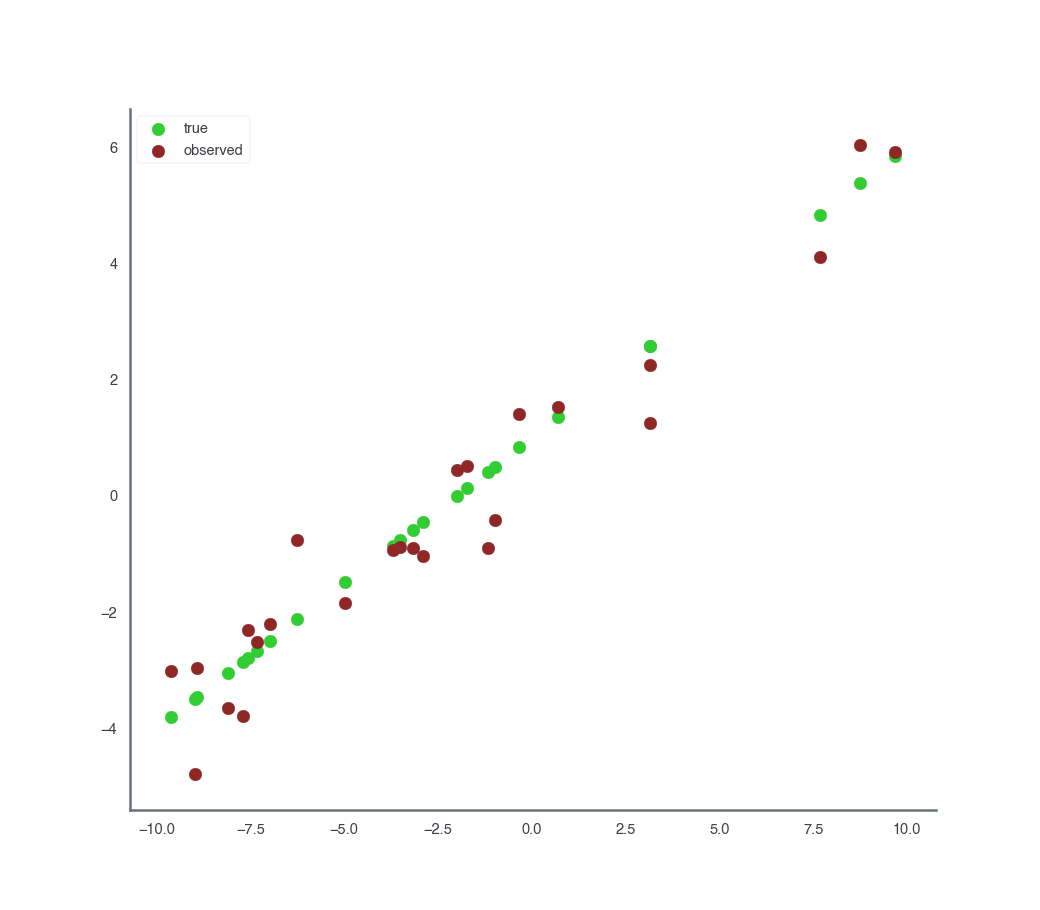

In [7]:
fig, ax = plt.subplots()


ax.scatter(x_obs, y_true, c='limegreen', label='true')
ax.scatter(x_obs, y_obs, c=dark, label='observed')
ax.legend()

Notice that I have **not** placed error bars on the data point. **Data do not have errors**, the model has uncertainty. This is a key concept to probability theory. To understand, let's sample from our **observation** model many times to understand this.

<IPython.core.display.Javascript object>


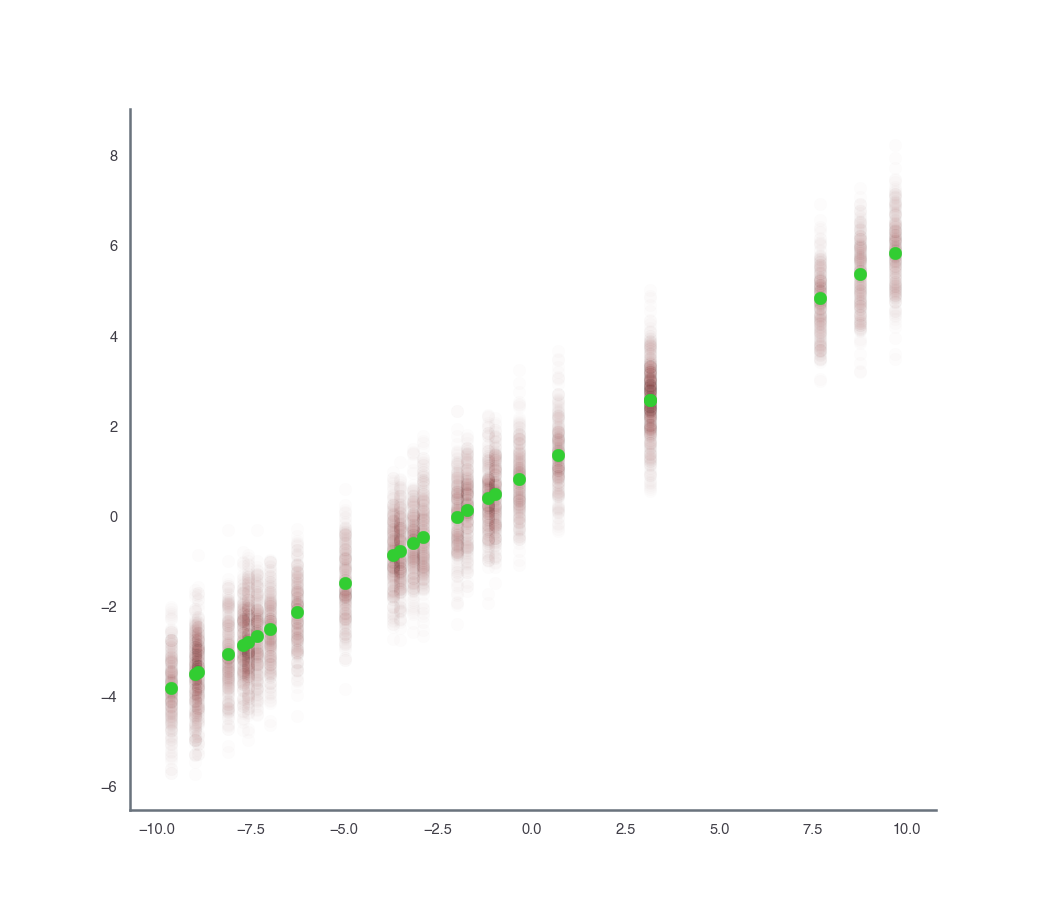

In [8]:
fig, ax = plt.subplots()


for i in range(250):
    
    y_obs_tmp =y_true + np.random.normal(loc=0, scale=y_sig, size=len(x_obs))
    
    ax.scatter(x_obs, y_obs_tmp, c=dark, alpha=0.01)
    
ax.scatter(x_obs, y_true, c='limegreen')

### Least Squares. 

The easiest way to fit a line is with least squares. this method is generally one you should never use in astronomy. It never applies to the data sets that we have.

In [9]:
A = np.vstack((np.ones_like(x_obs), x_obs)).T
C = np.diag((y_sig * np.ones_like(y_obs) ) * (y_sig * np.ones_like(y_obs) ))
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_obs)))

<IPython.core.display.Javascript object>


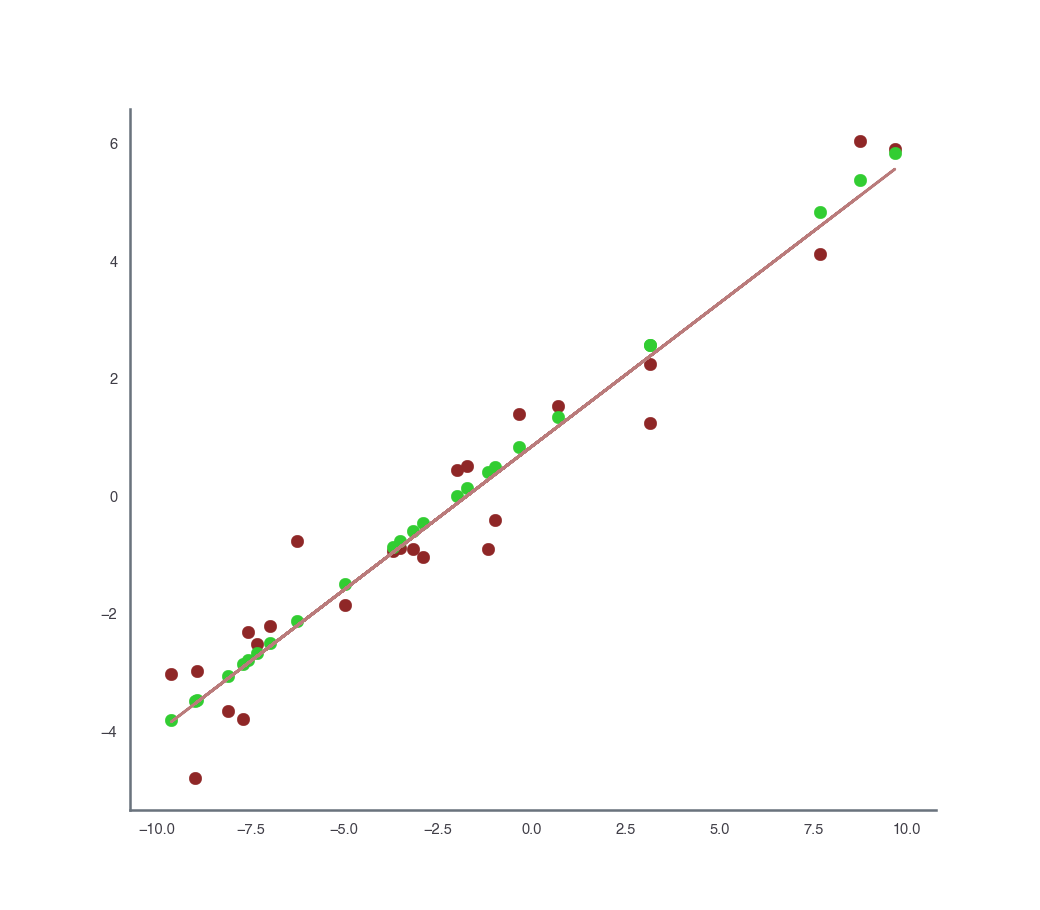

In [10]:
fig, ax = plt.subplots()


ax.scatter(x_obs, y_obs, c=dark)

ax.scatter(x_obs, y_true, c='limegreen')


ax.plot(x_obs, linear(x_obs,m_ls, b_ls), color=mid )

### Stan and proper Bayesian fitting

We will now use [Stan](https://mc-stan.org), a probabilistic programming language to learn the posterior distribution of the model. Stan implements a form of Hamiltonian Monte Carlo to integrate the posterior. There are many many many MCMC samplers all tuned for different purposes. If you would like more information of different samplers, when they should be used etc., come see me!


Let's take a look at how we write a model in Stan

In [11]:
!cat fit_yline.stan

data {

  int<lower=0> N; // number of data points
  vector[N] x_obs; // x observations
  vector[N] y_obs; // y observations  
  real<lower=0> sigma; // homoskedastic measurement error

  int<lower=0> N_model; // number of data points for line
  vector[N_model] x_model; //where to evaluate the model

}


transformed data {
  vector[N] x_std;
  vector[N] y_std;

  real x_mean = mean(x_obs);
  real x_sd = sd(x_obs);

  real y_mean = mean(y_obs);
  real y_sd = sd(y_obs);
  real sigma_std = sigma / y_sd;
  
  
  x_std = (x_obs - x_mean) / x_sd;
  y_std = (y_obs - y_mean) / y_sd;
  
}




parameters {
  
  real m_std; //slope of the line
  real b_std; //intercept of the line

}

transformed parameters {

  // latent y values not obscured by measurement error
  vector[N] y_std_true = m_std * x_std + b_std;

}

model {

  // weakly informative priors

  m_std ~ normal(0,5);
  b_std ~ normal(0,5);

  // likelihood

  y_std ~ normal(y_std_true, sigma_std);



}

generated quantities {

  real m

In [12]:
stan_model = stan_utility.compile_model(filename='fit_yline.stan', model_name='yline')

Using cached StanModel


In [13]:
x_model = np.linspace(-10,10,100)

stan_data = dict(N=len(x_obs),
                 x_obs=x_obs,
                 y_obs=y_obs,
                 sigma=y_sig,
                 N_model=100,
                 x_model=x_model)

In [14]:
fit = stan_model.sampling(data=stan_data,chains=4,iter=2000, seed=234571)

<IPython.core.display.Javascript object>


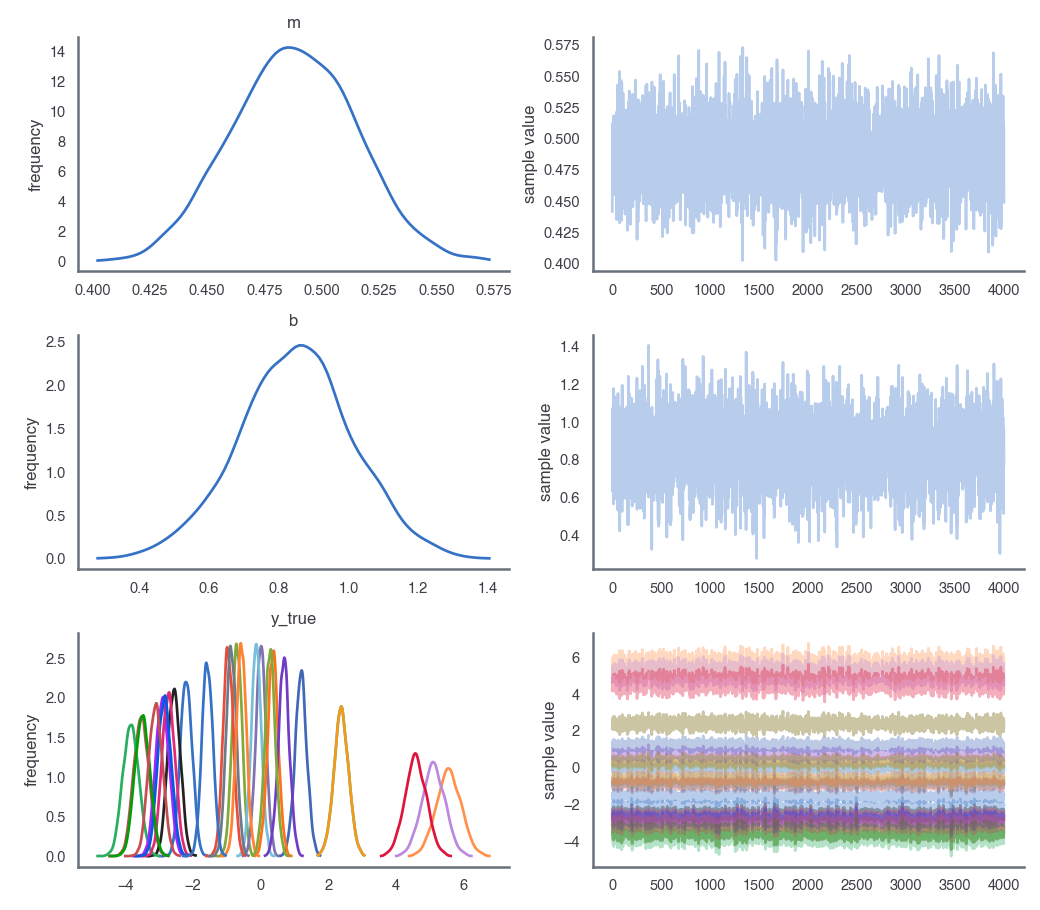

In [15]:
fit.plot(pars=['m', 'b', 'y_true'])
plt.tight_layout()

<IPython.core.display.Javascript object>


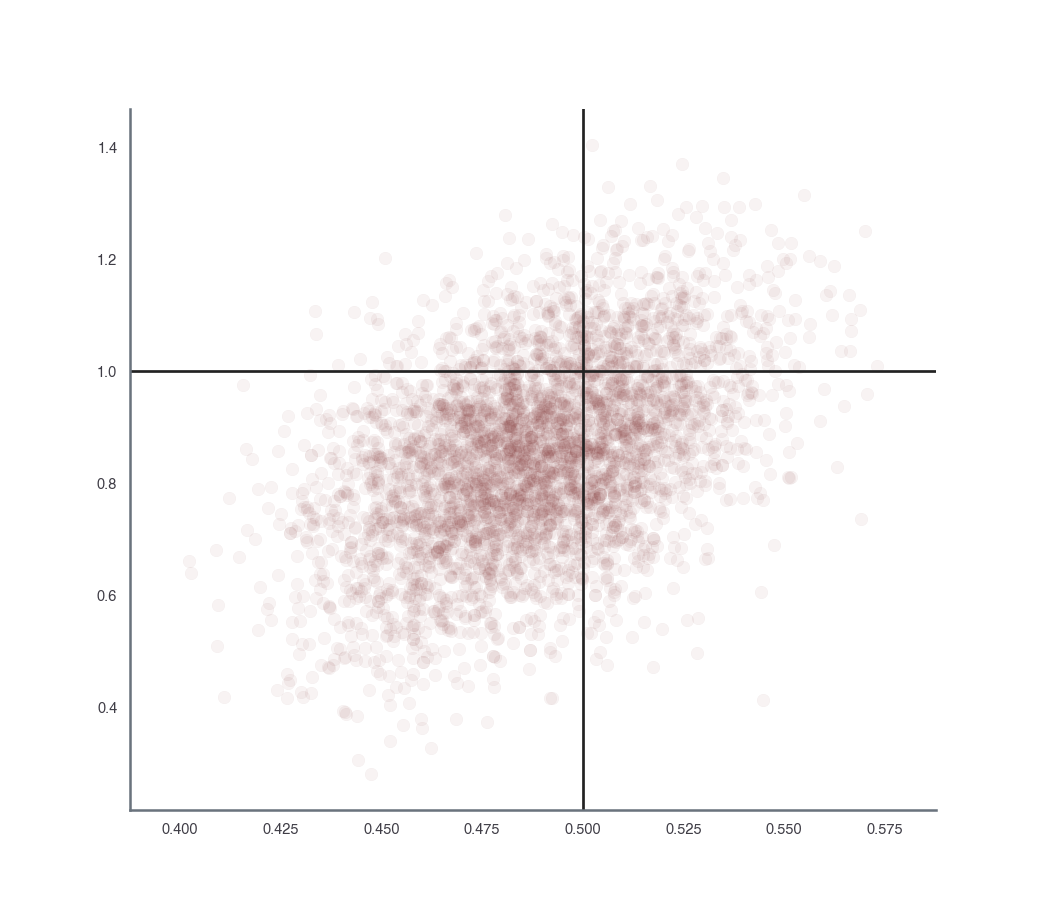

In [16]:
fig, ax = plt.subplots()

chain = fit.extract()


ax.scatter(chain['m'], chain['b'], c=dark_highlight, alpha=.05)


ax.axvline(m_true,color='k')
ax.axhline(b_true,color='k')

<IPython.core.display.Javascript object>


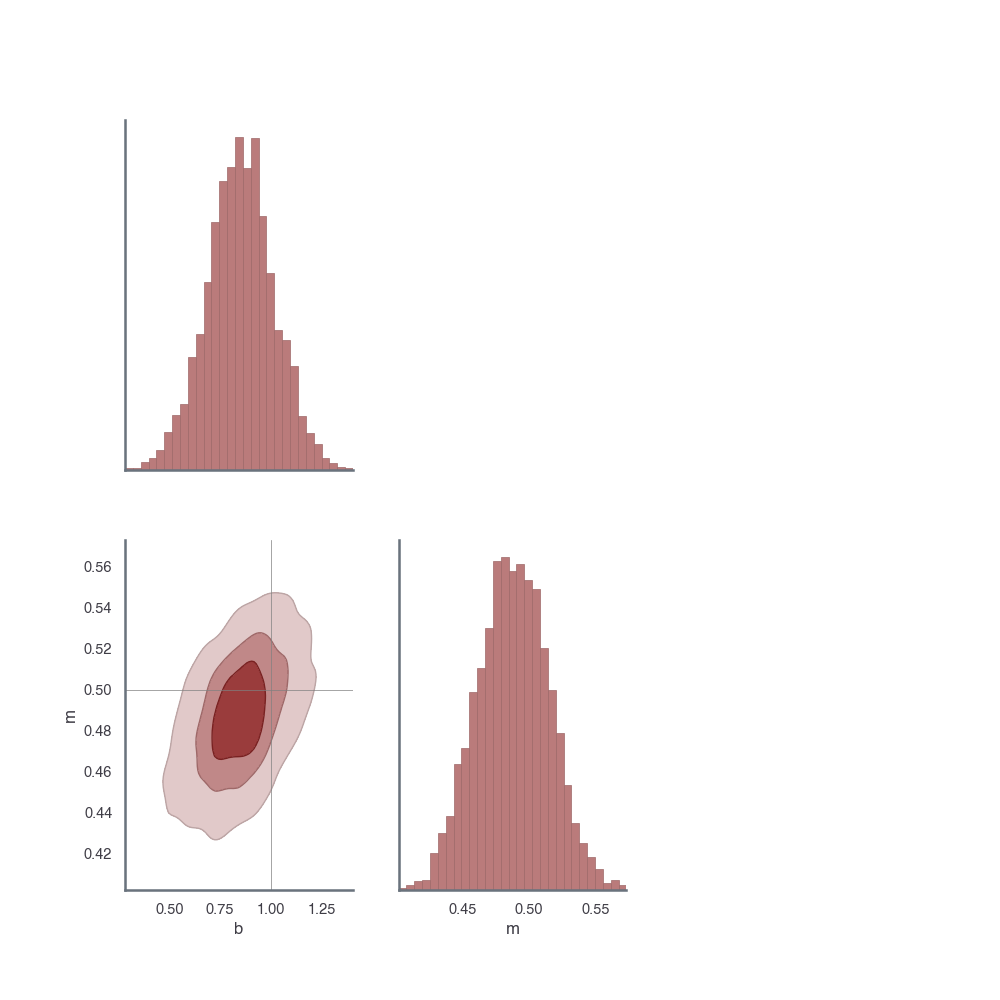

In [17]:
chain = fit.extract()

bayescorner(params=[chain['m'], chain['b']],
            param_names=['m', 'b'],
            truth=[m_true, b_true  ]
);

<IPython.core.display.Javascript object>


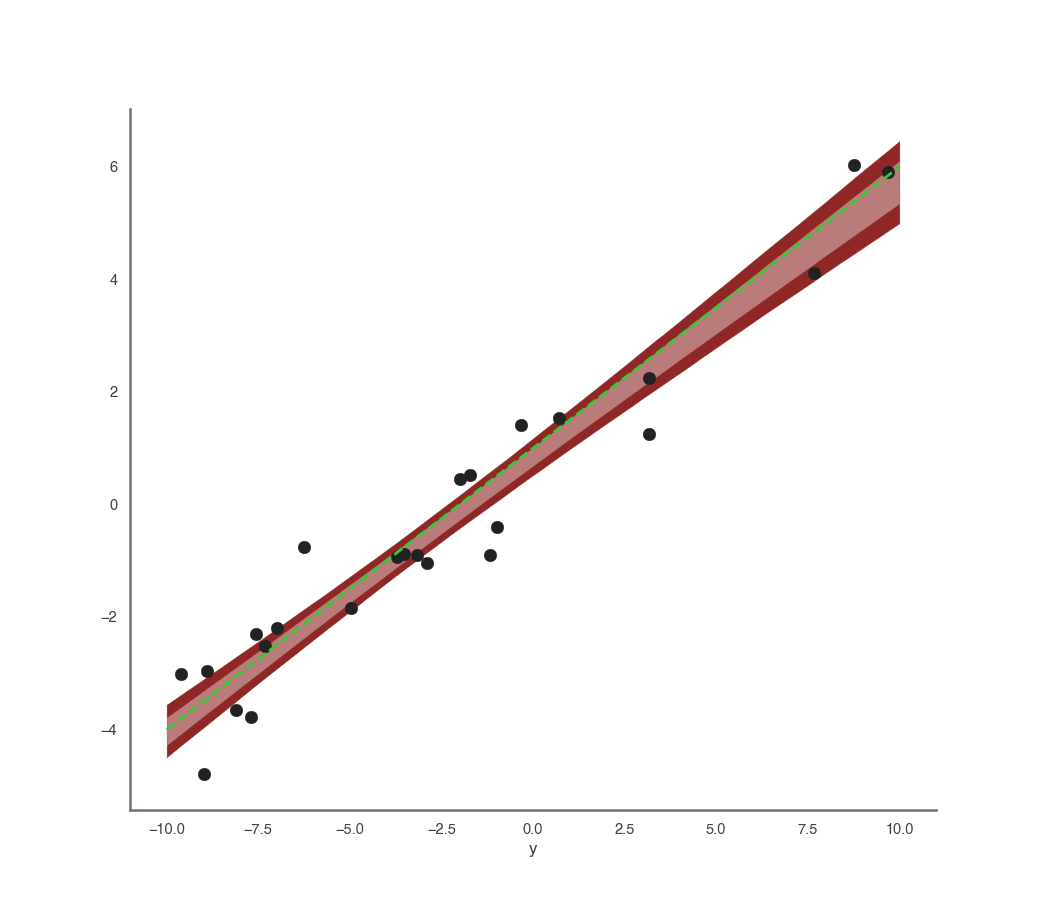

Text(0.5, 0, 'y')

In [18]:
fig, ax = plt.subplots()

chain = fit.extract()

level = 95

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=dark)

level = 68

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=mid)

ax.plot(x_model, m_true*x_model+b_true,color='limegreen',ls='--',zorder=10000)

ax.scatter(x_obs, y_obs, c='k')

ax.set_xlabel('x')
ax.set_xlabel('y')

<IPython.core.display.Javascript object>


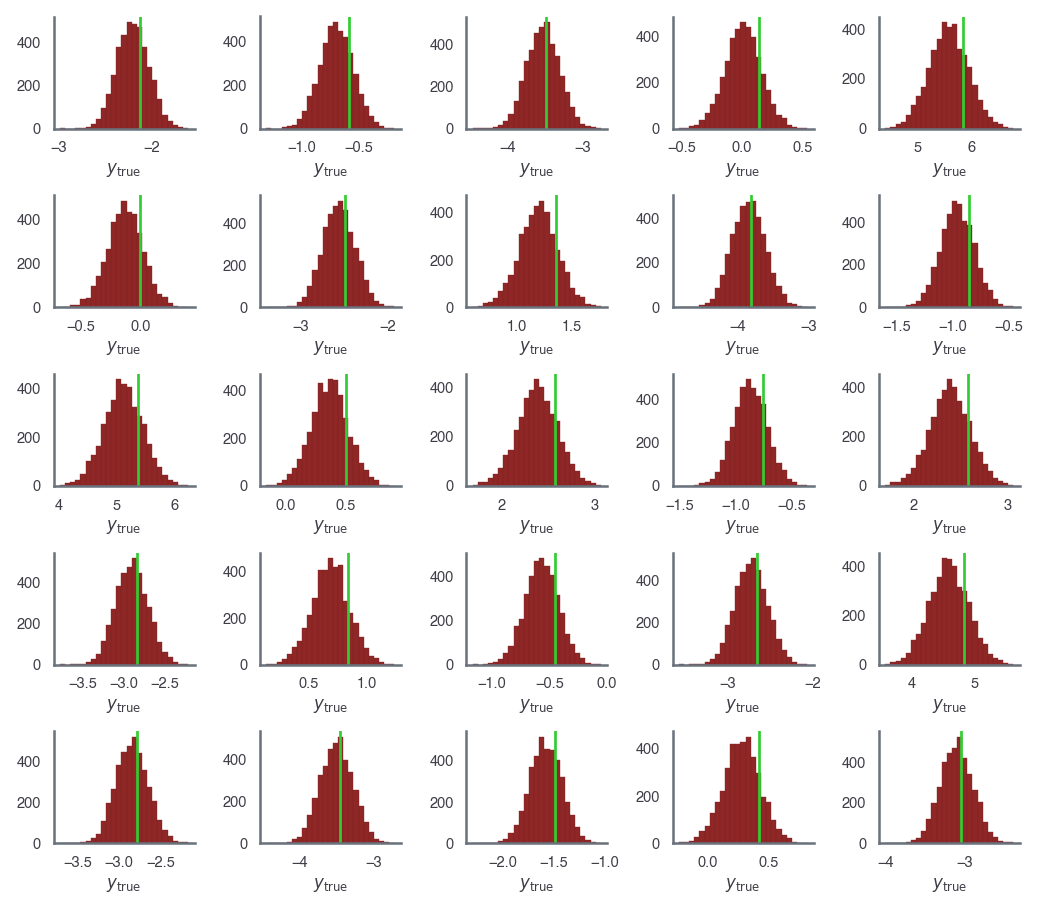

In [19]:
fig, axes = plt.subplots(5,5)

itr = 0

for i in range(5):
    for j in range(5):
        
        axes[i,j].hist(chain['y_true'][:,itr],ec=dark_highlight,fc=dark, bins=25)
        axes[i,j].axvline(y_true[itr],color='limegreen')
        axes[i,j].set_xlabel(r'$y_{\rm true}$')
        
        
        itr+=1
        
plt.tight_layout()

### Posterior Predictive Checks

An essential part of understanding a if a model that we conditioned on the data is an accurate description of that data is to ask the question of **"Does the posterior of the model generate data that looks like the data we observed?"** This is perfectly encapsulated within the concept of **posterior predictive checks**. First, we start with the posterior predictive distribution. 

$$
\pi\left(y^{\mathrm{rep}} | y\right)=\int d \theta \pi\left(y^{\mathrm{rep}} | \theta\right) \pi(\theta | y)
$$

In words, this distribution ask, what is the probability of future or replicated data given the data we observed. It is achieved by convolving the likelihood of future data with posterior of our model that we conditioned on the data we observed. 

Stan allows us to easily compute this future data by drawing replicated data from the likelihood at each iteration of our MCMC. There are several ways to access PPCs that vary from problem to problem. Here, we plot these replicated data along with our observed data and visually confirm that indeed our model and its uncertainty can generate data that look like our observed data 



<IPython.core.display.Javascript object>


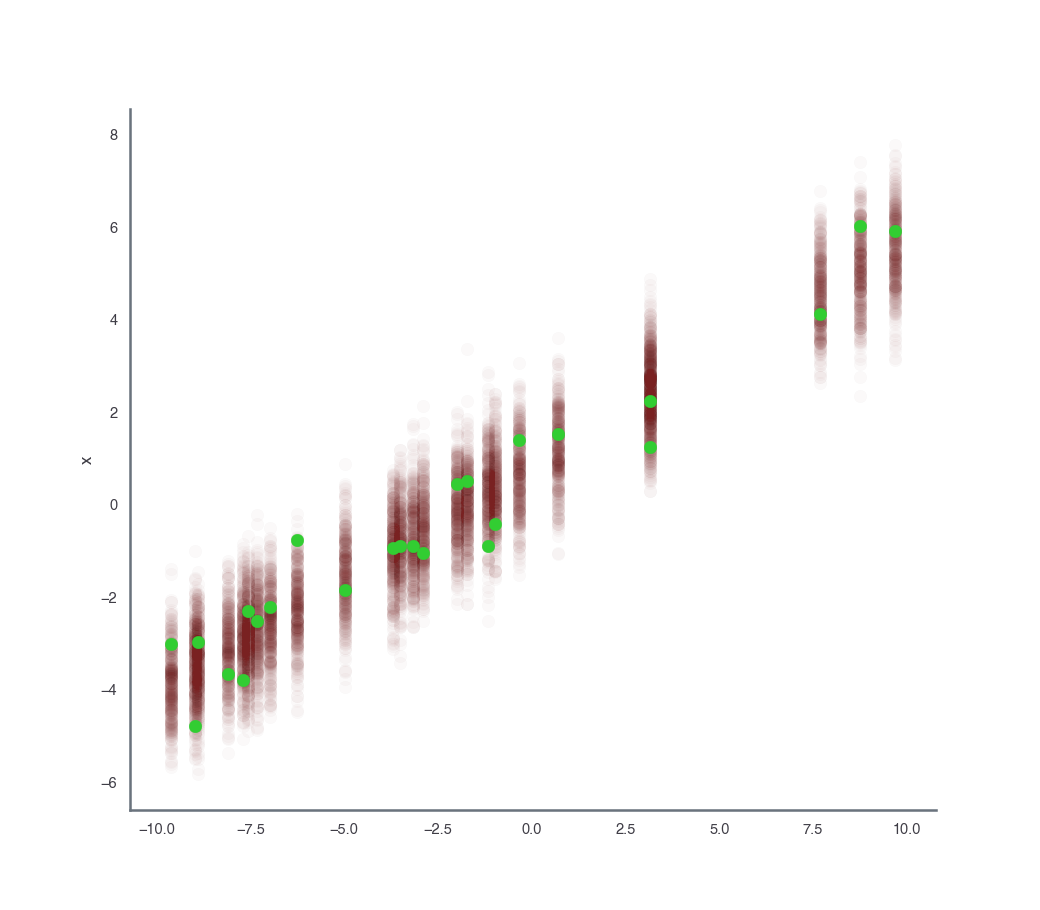

Text(0, 0.5, 'x')

In [20]:
fig, ax = plt.subplots()


for ppc in chain['ppc'][::10]:
    
    ax.scatter(x_obs,ppc, c=dark_highlight, alpha=.025)
    
    
ax.scatter(x_obs, y_obs,c='limegreen')


ax.set_ylabel('y')
ax.set_ylabel('x')

<IPython.core.display.Javascript object>


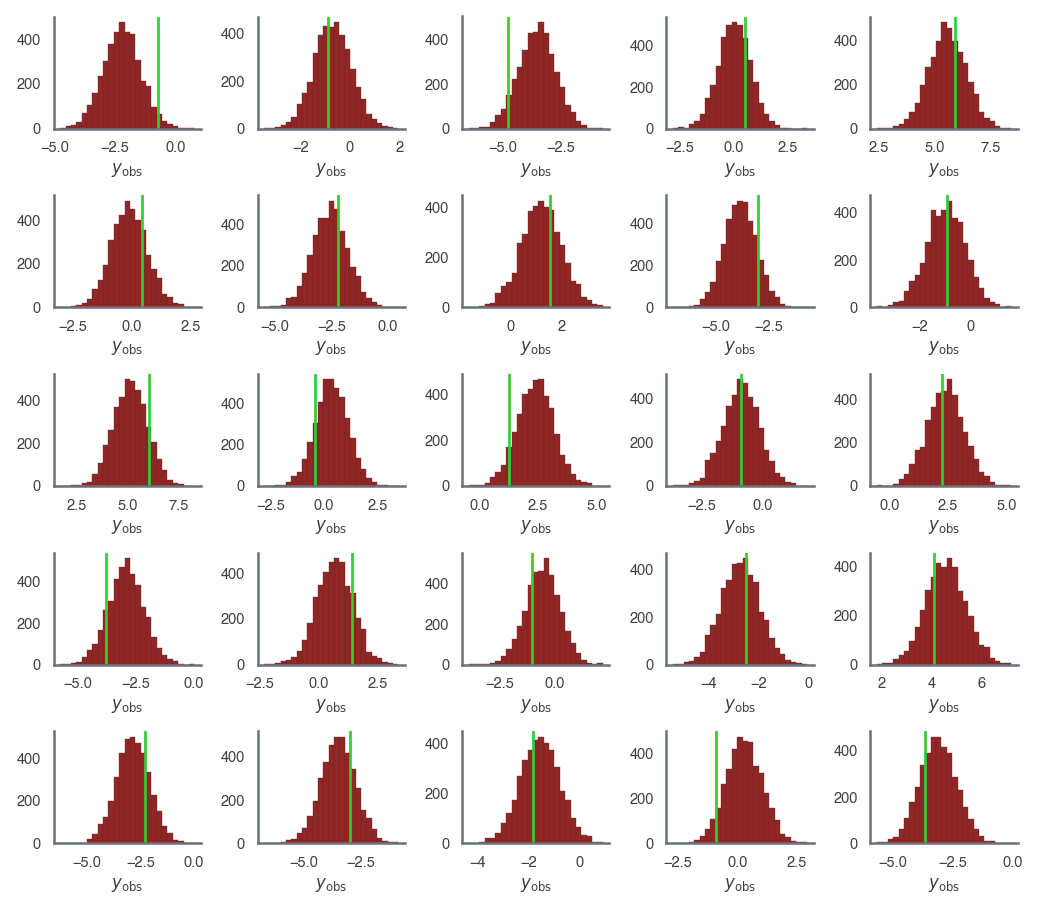

In [21]:
fig, axes = plt.subplots(5,5)

itr = 0

for i in range(5):
    for j in range(5):
        
        axes[i,j].hist(chain['ppc'][:,itr],ec=dark_highlight,fc=dark, bins=25)
        axes[i,j].axvline(y_obs[itr],color='limegreen')
        axes[i,j].set_xlabel(r'$y_{\rm obs}$')
        
        
        itr+=1
        
plt.tight_layout()

### Fitting for $\sigma$

In [22]:
stan_model_sigma = stan_utility.compile_model(filename='fit_yline_sigma.stan', model_name='yline2_sigma')

Using cached StanModel


In [23]:
x_model = np.linspace(-10,10,100)

stan_data = dict(N=len(x_obs),
                 x_obs=x_obs,
                 y_obs=y_obs,
                 N_model=100,
                 x_model=x_model)

In [24]:
fit = stan_model_sigma.sampling(data=stan_data,chains=4,iter=2000, seed=234571)

<IPython.core.display.Javascript object>


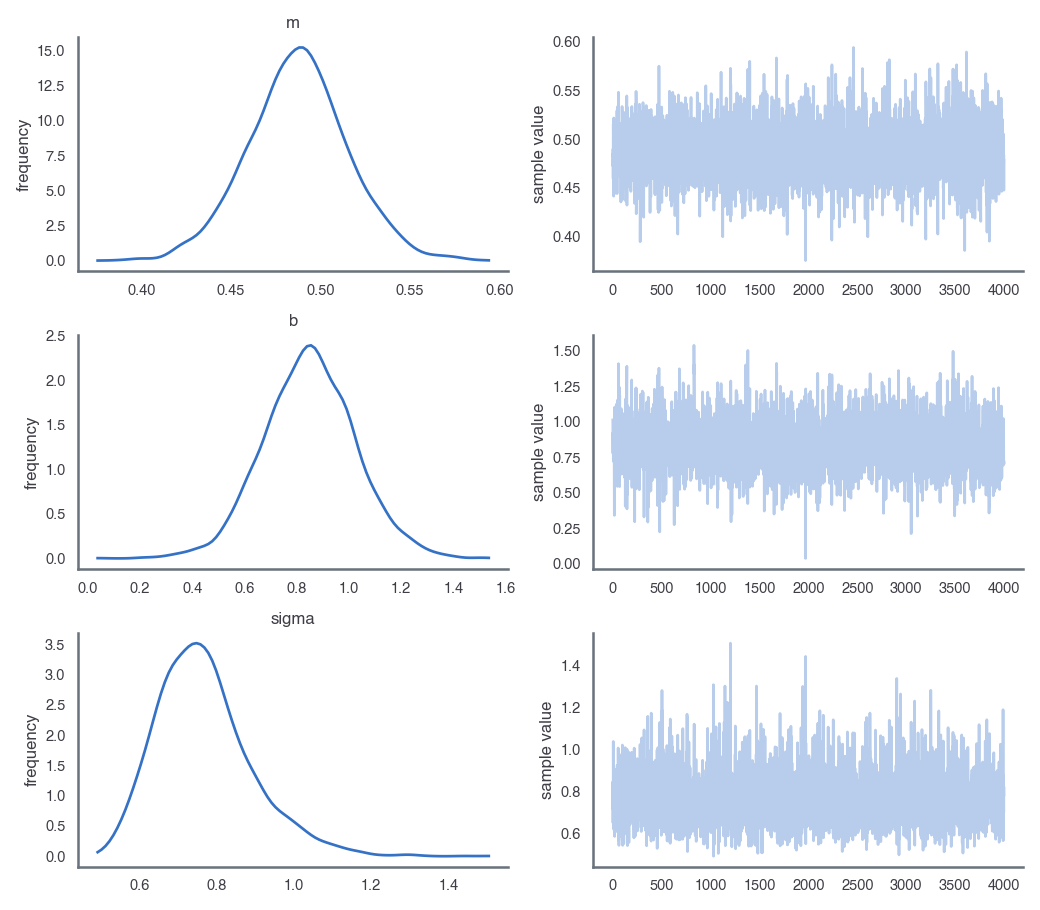

In [25]:
fit.plot(pars=['m', 'b', 'sigma'])
plt.tight_layout()

<IPython.core.display.Javascript object>


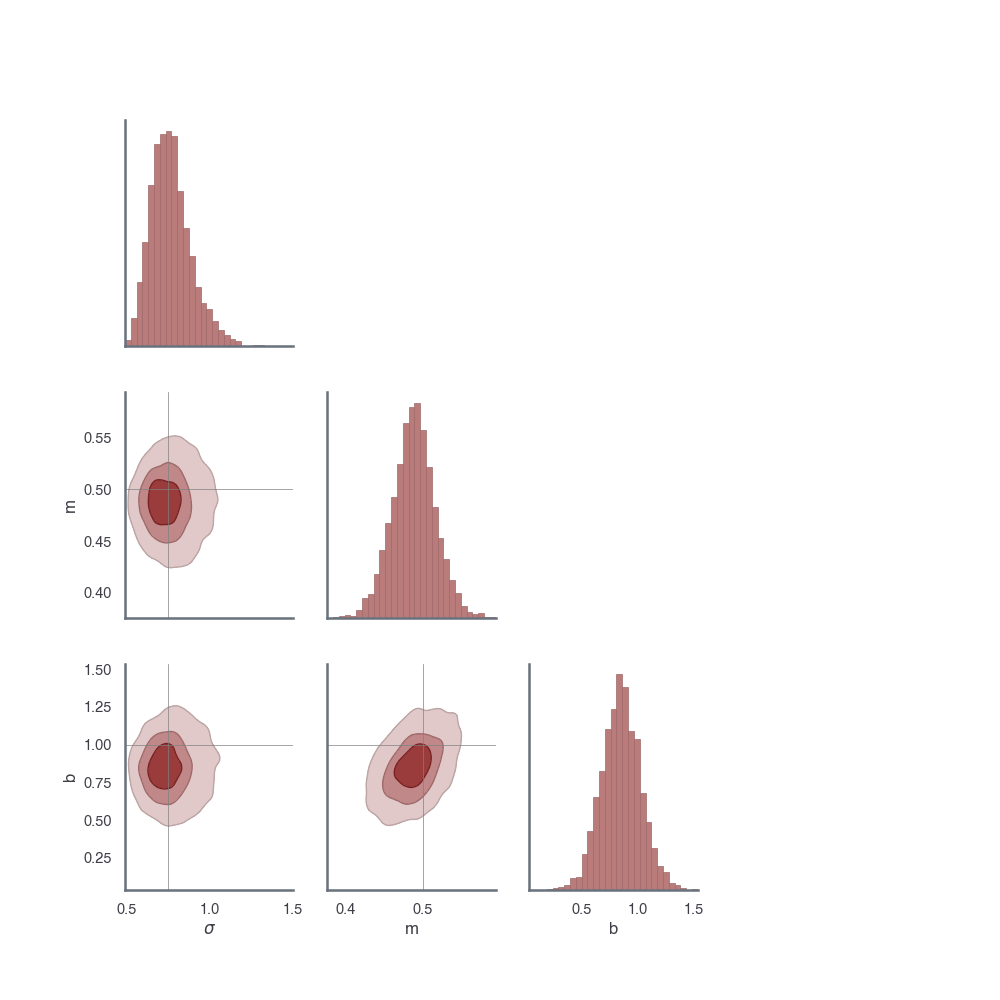

In [26]:
chain = fit.extract()

bayescorner(params=[chain['m'], chain['b'], chain['sigma']],
            param_names=['m', 'b', r'$\sigma$'],
            truth=[m_true, b_true , y_sig ]);

## Systematics

We will now talk about systematics. Once again, we are in a situation where there the discussion must be focused on specific models. When we encounter systematics in the literature, they are typically presented as an additional factor, added in quadrature to our "statistical" error. They can be derived by calibrating the inability of our derived confidence intervals to properly capture the true value.


However, let's consider what this means. Adding on additional "uncertainty" in quadrature assumes that our measurement has a Gaussian covariance matrix, and that this additional uncertainty is also Gaussian. *Nature is not so kind*. Furthermore, the prescence of systematics simply identifies that our model is *not capturing the generative model of our data*.

In [27]:
systematic = 2.

y_obs = y_true + np.random.normal(loc=0, scale=y_sig*systematic, size=len(x_obs))

In [28]:
x_model = np.linspace(-10,10,100)

stan_data = dict(N=len(x_obs),
                 x_obs=x_obs,
                 y_obs=y_obs,
                 sigma=y_sig,
                 N_model=100,
                 x_model=x_model)

In [29]:
fit_sys = stan_model.sampling(data=stan_data,chains=4,iter=2000, seed=234571)

<IPython.core.display.Javascript object>


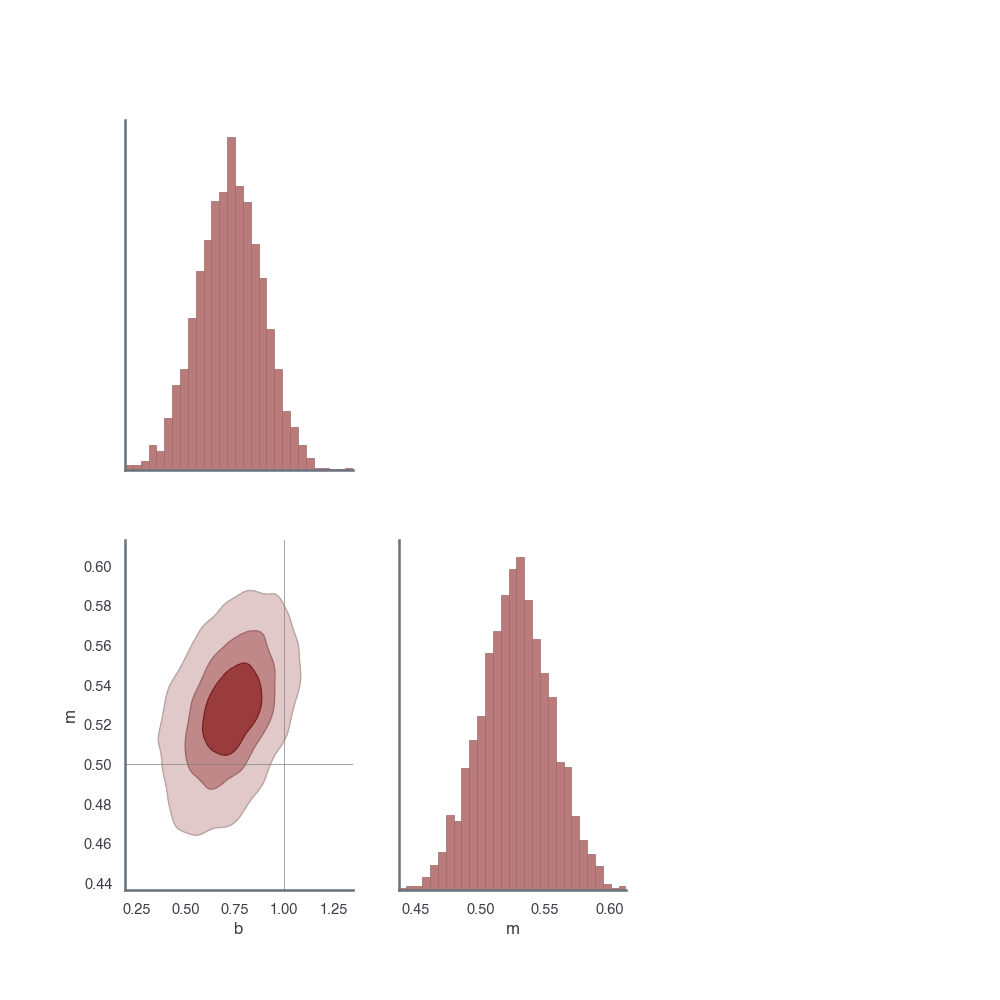

In [30]:
chain = fit_sys.extract()

bayescorner(params=[chain['m'], chain['b']],
            param_names=['m', 'b'],
            truth=[m_true, b_true  ]
);

<IPython.core.display.Javascript object>


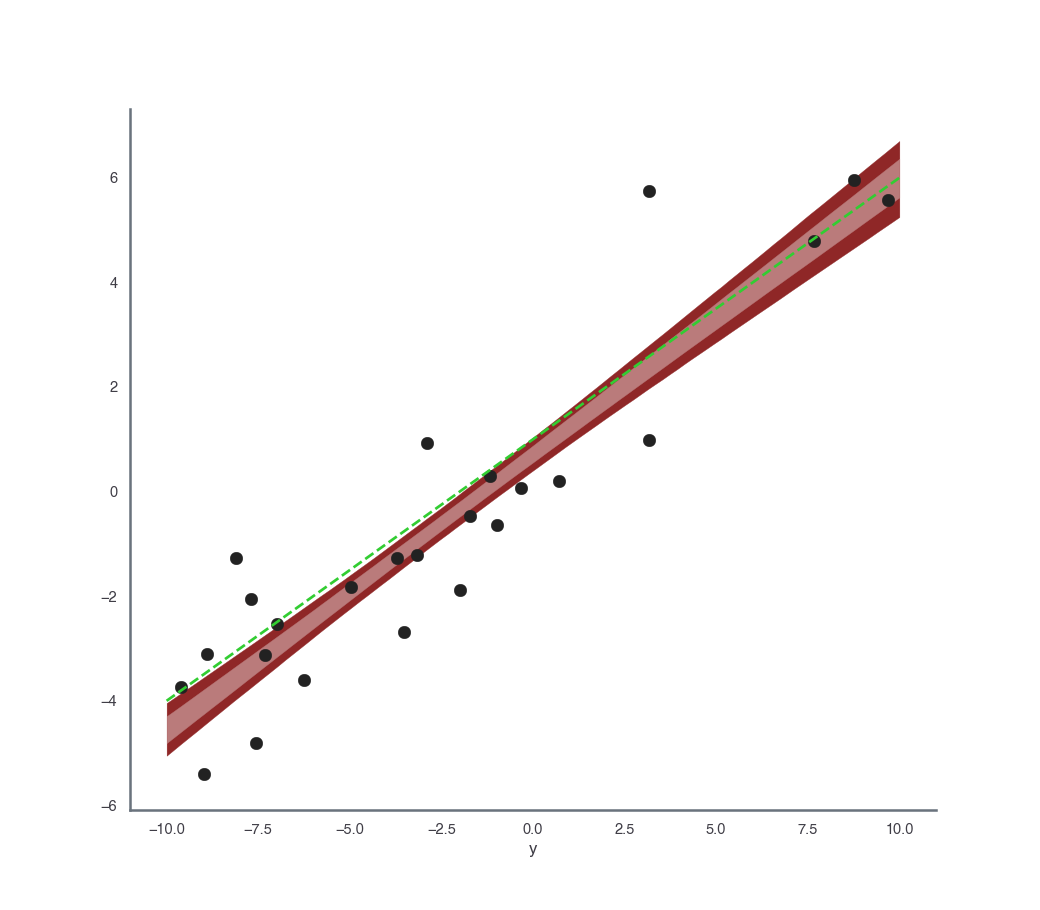

Text(0.5, 0, 'y')

In [31]:
fig, ax = plt.subplots()

chain = fit_sys.extract()

level = 95

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=dark)

level = 68

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=mid)

ax.plot(x_model, m_true*x_model+b_true,color='limegreen',ls='--',zorder=10000)

ax.scatter(x_obs, y_obs, c='k')

ax.set_xlabel('x')
ax.set_xlabel('y')

# Measurement Error

Another common issue in analysis is regression where there is an uncertainty in both the variables. This is a delicate problem and there is no one proper combination of likelihood and priors that can handle the issue properly. However, there are several ways that are known to be incorrect.

## Generating data 

This time we will use Stan to generate the data to demonstrate its capabilities.



In [39]:
model_gen = stan_utility.compile_model('generate_data_xy.stan',model_name='xygen')

n_obs = 20
slope=2.
intercept=1.
sigma_x=1.
sigma_y=3.
x_min = -10.
x_max = 10.


gen = model_gen.sampling(data=dict(n_obs=n_obs,
                                   slope=slope,
                                   intercept=intercept,
                                   sigma_x=sigma_x,
                                   sigma_y=sigma_y,
                                   x_min=x_min,
                                   x_max=x_max ),
                         seed=194838, algorithm='Fixed_param', iter=1, chains=1)

N_model = 100
x_model=np.linspace(x_min, x_max, N_model)
data_xy = dict(N = gen.extract()['N'].astype(np.int64)[0],
            x_obs = gen.extract()['x_obs'][0,:],
            y_obs = gen.extract()['y_obs'][0,:],
            y_latent = gen.extract()['y_latent'][0,:],
            sigma_x=sigma_x,
            sigma_y=sigma_y,
            N_model=N_model,
            x_model=x_model

           )



#pystan.stan_rdump(data, 'xyerr.data.R')

Using cached StanModel


<IPython.core.display.Javascript object>


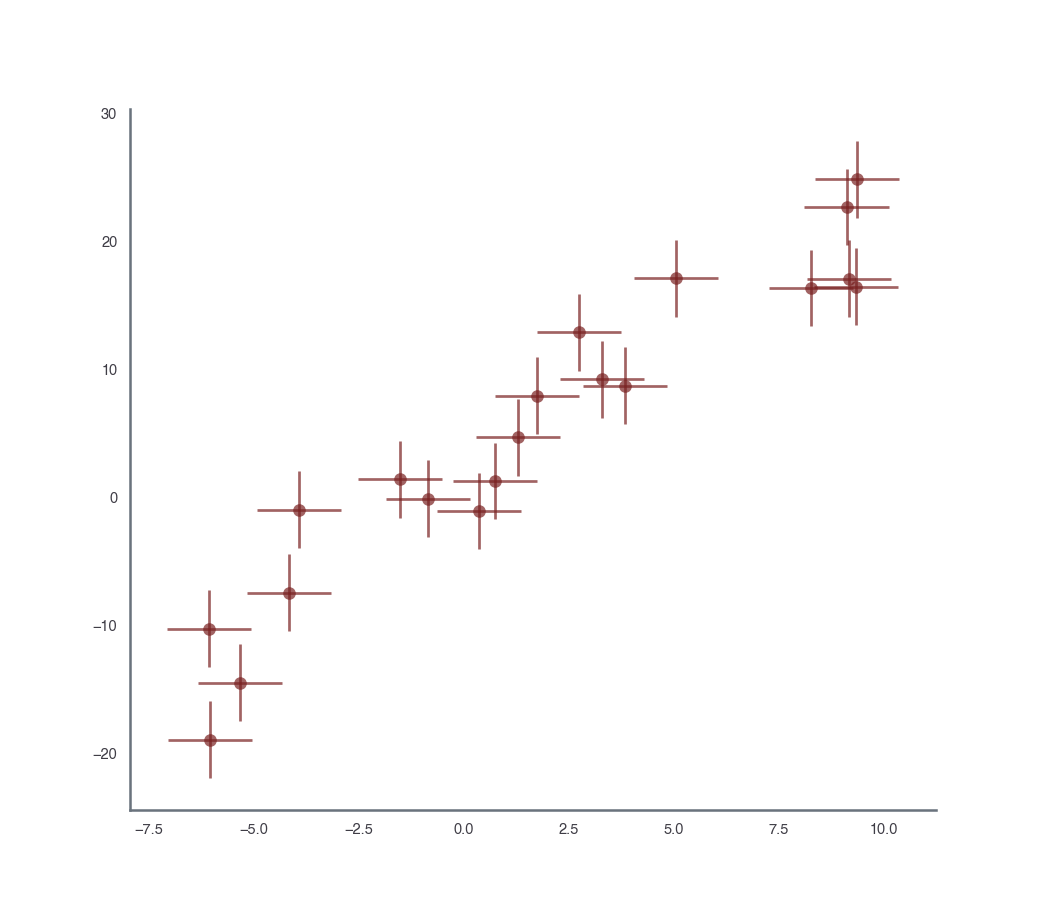

<ErrorbarContainer object of 3 artists>

In [38]:
fig, ax = plt.subplots()


ax.errorbar(data_xy['x_obs'],
            data_xy['y_obs'], 
            yerr=data_xy['sigma_y'], 
            xerr=data_xy['sigma_x'] ,fmt='o', color=dark_highlight, alpha= .7)



There are many bad methods and these have all been demonstrated in [Kelly (2007)](http://adsabs.harvard.edu/abs/2007ApJ...665.1489K).
![alt text](xy.png "Title")

In [36]:
model_yx = stan_utility.compile_model('fit_xyline.stan', model_name='xyfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL xyfit_863f377cc6c2fb7f890bd32ac8b4bc58 NOW.


In [43]:
fit_xy = model_yx.sampling(data=data_xy, seed=352435, iter=4000)

<IPython.core.display.Javascript object>


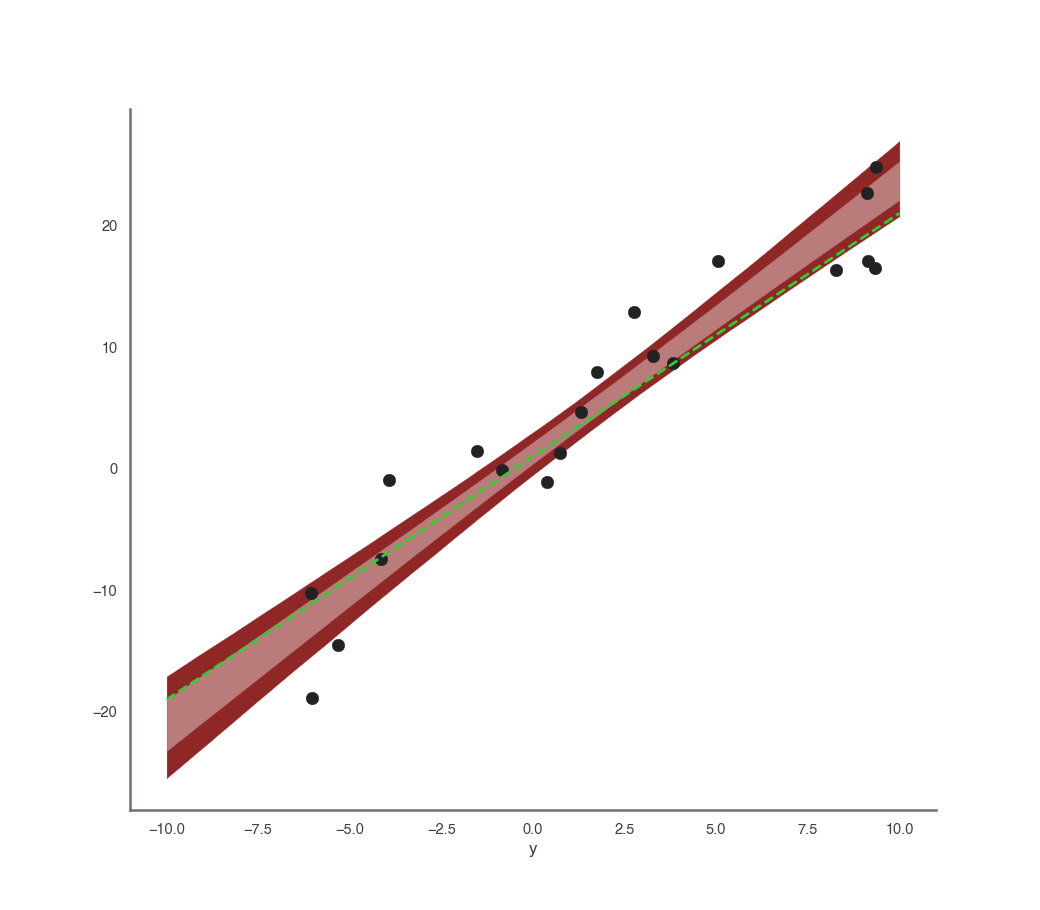

Text(0.5, 0, 'y')

In [45]:
fig, ax = plt.subplots()

chain = fit_xy.extract()

level = 95

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=dark)

level = 68

ax.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color=mid)

ax.plot(x_model, slope*x_model+intercept,color='limegreen',ls='--',zorder=10000)

ax.scatter(data_xy['x_obs'], data_xy['y_obs'], c='k')

ax.set_xlabel('x')
ax.set_xlabel('y')